# Thesis data generation and analysis
---

## Setup

### Imports, variables and plotting setup

In [1]:
import os
import numpy as np
import string
import random

import seaborn as sns; sns.set(color_codes=True)
from scipy import stats, integrate
import matplotlib.pyplot as plt
%matplotlib inline


# import configuration variable with path
# to the Golang code of the experiment
from config import EXPERIMENT_PATH

# build Golang program
os.system("go build -o " + EXPERIMENT_PATH + "/thesis " + EXPERIMENT_PATH + "/*.go")


# plotting config
plt.style.use('seaborn-talk')
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)

np.random.seed(2424)

### Utility functions

In [2]:
# run experiment with given params
def runExperiment(name, algo="mt", i=10, op="build"):
    os.system(EXPERIMENT_PATH + "/thesis " + "-algo=" + algo +  " -op=" + op + " -name=" + name + " -iter=" + str(i))
    
# clean source and results folders
def cleanupSource():
    os.system("rm " + EXPERIMENT_PATH + "/source/*.txt")

def cleanupResults():
    os.system("rm " + EXPERIMENT_PATH + "/results/*.txt")

In [3]:
# generate n transactions of uniformly distributed length
def genTransactions(lengths, name, sort=False):
    
    # the function gen_string is vectorized, ready to 
    # process arrays 
    vfunc = np.vectorize(random_string)
    
    # generates strings of given lengths
    samples = vfunc(lengths.astype(int))
    
    if sort:
        samples.sort()
    
    with open(EXPERIMENT_PATH + '/source/' + name, 'w') as output:
        for sample in samples:
            output.write(sample + '\n')

# generate random string of specified length
def random_string(length):
    return ''.join(random.choice(string.ascii_letters) for m in range(length)).upper()

In [4]:
def computeStats(trials):
    # compute means and standard deviations
    means = np.mean(trials[1:,:], axis=1)
    stds = np.std(trials[1:,:], axis=1)
    
    return means, stds

In [5]:
def plotDistribution(data, title):
    plt.hist(data, bins=200, normed=True)
    plt.title(title)

In [6]:
def toSnakeCase(string):
    return string.replace(' ', '_').lower()

### Generate data

In [7]:
# Negative Exponential with λ= 1#  Negati 
# In probability theory and statistics, the exponential distribution
# (also known as negative exponential distribution) is the probability 
# distribution that describes the time between events in a Poisson 
# point process, i.e. a process in which events occur continuously 
# and independently at a constant average rate

#  Beta is the scale parameter, which is the inverse of the rate parameter \lambda = 1/\beta.

BETA = 500

def genRandExp(n_samples):
    exponential_samples = np.rint(np.random.exponential(BETA, n_samples))
    # plotDistribution(exponential_samples, 'Exponential')
    # print(exponential_samples)
    return exponential_samples

In [8]:
# Uniform samples in (0,2) range

def genRandUni(n_samples):
    uniform_samples = np.rint(np.random.uniform(900, 1100, n_samples))
    # plotDistribution(uniform_samples, 'Uniform')
    # print(uniform_samples)
    return uniform_samples

In [9]:
# This distribution corresponds to the one presented in the papers# This di 
# I.e. 0.5 (rand)^0.5 is the same as a triangular distribution with left = 0, right = 0.5, mode = 0.5

def genRandTri(n_samples):
    triang = np.rint(np.random.triangular(left=0, mode=1100, right=1100, size=n_samples))
    # plotDistribution(triang, 'Triangular')
    # print(triang)
    return triang

In [10]:
def genExpTransactions(n, name, sort):
    lenghts = genRandExp(n)
    genTransactions(lenghts, name, sort)

In [11]:
def genUniTransactions(n, name, sort):
    lenghts = genRandUni(n)
    genTransactions(lenghts, name, sort)

In [12]:
def genTriTransactions(n, name, sort):
    lenghts = genRandTri(n)
    genTransactions(lenghts, name, sort)

---

## Experiment

### Uniformly random distributed transactions

In [13]:
def genUniformData(rnge):
    for i in range(rnge[0], rnge[1], rnge[2]):
        SAMPLE = str(i) + '_uniform_samples.txt'
        
        # Only create the data if it doesn't exist yet.
        # Unnecessary to generate random data multiple times.
        if Path(EXPERIMENT_PATH + '/source/' + SAMPLE).exists() == false:
            # generate data (no sorting)
            genTriTransactions(i, SAMPLE, False)

In [14]:
def randUniformExperiment(algo, trials, rnge):
    for i in range(rnge[0], rnge[1], rnge[2]):
        SAMPLE = str(i) + '_uniform_samples.txt'

        # run exeperiment
        runExperiment(SAMPLE, i=trials, algo=algo)

In [15]:
def getResults(algo, trials, rnge):
    RES_PATH = '/results/result_' + algo + '_'
    NUM_TRIALS = trials

    build_t = np.arange(NUM_TRIALS)
    build_m = np.arange(NUM_TRIALS)
    veri_t = np.arange(NUM_TRIALS)
    veri_m = np.arange(NUM_TRIALS)

    for i in range(rnge[0], rnge[1], rnge[2]):
        SAMPLE = str(i) + '_uniform_samples.txt'

        # load data in-memory for analysis
        result = np.loadtxt(EXPERIMENT_PATH + RES_PATH + SAMPLE, dtype='int', delimiter=', ')
        build_t = np.vstack([build_t, result[:,0]])
        build_m = np.vstack([build_m, result[:,1]])
        veri_t = np.vstack([veri_t, result[:,2]])
        veri_m = np.vstack([veri_m, result[:,3]])
    

    return build_t, build_m, veri_t, veri_m

In [16]:
RANGE = 100, 10000, 50
TRIALS = 30


# -- START EXPERIMENT -- #

#cleanupResults()
#cleanupSource()
#genUniformData(RANGE)

randUniformExperiment('hl', TRIALS, RANGE)
hl_build_t, hl_build_m, hl_veri_t, hl_veri_m = getResults('hl', TRIALS, RANGE)
hl_build_t_means, hl_build_t_stds = computeStats(hl_build_t)
hl_build_m_means, hl_build_m_stds = computeStats(hl_build_m)
hl_veri_t_means, hl_veri_t_stds = computeStats(hl_veri_t)
hl_veri_m_means, hl_veri_m_stds = computeStats(hl_veri_m)


randUniformExperiment('mt', TRIALS, RANGE)
mt_build_t, mt_build_m, mt_veri_t, mt_veri_m = getResults('mt', TRIALS, RANGE)
mt_build_t_means, mt_build_t_stds = computeStats(mt_build_t)
mt_build_m_means, mt_build_m_stds = computeStats(mt_build_m)
mt_veri_t_means, mt_veri_t_stds = computeStats(mt_veri_t)
mt_veri_m_means, mt_veri_m_stds = computeStats(mt_veri_m)

randUniformExperiment('fmt', TRIALS, RANGE)
fmt_build_t, fmt_build_m, fmt_veri_t, fmt_veri_m = getResults('fmt', TRIALS, RANGE)
fmt_build_t_means, fmt_build_t_stds = computeStats(fmt_build_t)
fmt_build_m_means, fmt_build_m_stds = computeStats(fmt_build_m)
fmt_veri_t_means, fmt_veri_t_stds = computeStats(fmt_veri_t)
fmt_veri_m_means, fmt_veri_m_stds = computeStats(fmt_veri_m)

#randUniformExperiment('sl', TRIALS, RANGE)
sl_build_t, sl_build_m, sl_veri_t, sl_veri_m = getResults('sl', TRIALS, RANGE)
sl_build_t_means, sl_build_t_stds = computeStats(sl_build_t)
sl_build_m_means, sl_build_m_stds = computeStats(sl_build_m)
sl_veri_t_means, sl_veri_t_stds = computeStats(sl_veri_t)
sl_veri_m_means, sl_veri_m_stds = computeStats(sl_veri_m)

lenghts = np.arange(RANGE[0], RANGE[1], RANGE[2])

# -- END EXPERIMENT -- #

Done!


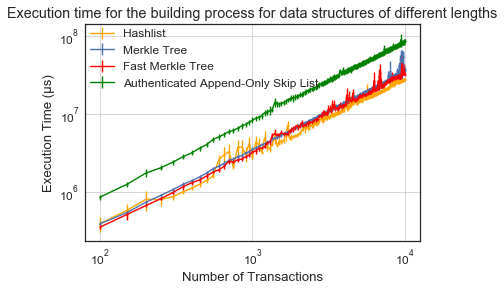

In [17]:
# build plot
title = 'Execution time for the building process for data structures of different lengths'
plt.errorbar(lenghts, hl_build_t_means, yerr=hl_build_t_stds, marker='o', markersize=2, color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_build_t_means, yerr=mt_build_t_stds, marker='o', markersize=2, label='Merkle Tree')
plt.errorbar(lenghts, fmt_build_t_means, yerr=fmt_build_t_stds, marker='o', markersize=2, color='red', label='Fast Merkle Tree')
plt.errorbar(lenghts, sl_build_t_means, yerr=sl_build_t_stds, marker='o', markersize=2, color='green', label='Authenticated Append-Only Skip List')
plt.title(title)
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Execution Time (µs)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
plt.savefig(toSnakeCase(title) + '.png', dpi = 400)
plt.xscale('log')
plt.yscale('log')
plt.savefig(toSnakeCase(title) + '_log.png', dpi = 400)
print('Done!')

Done!


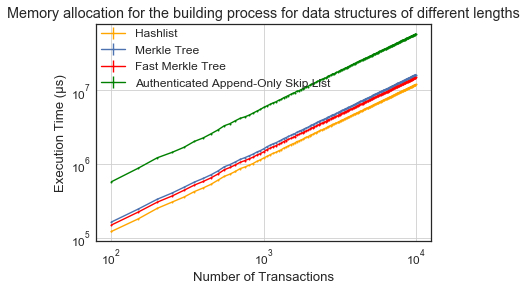

In [18]:
# build plot
title = 'Memory allocation for the building process for data structures of different lengths'
plt.errorbar(lenghts, hl_build_m_means, yerr=hl_build_m_stds, marker='o', markersize=2, color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_build_m_means, yerr=mt_build_m_stds, marker='o', markersize=2, label='Merkle Tree')
plt.errorbar(lenghts, fmt_build_m_means, yerr=fmt_build_m_stds, marker='o', markersize=2, color='red', label='Fast Merkle Tree')
plt.errorbar(lenghts, sl_build_m_means, yerr=sl_build_m_stds, marker='o', markersize=2, color='green', label='Authenticated Append-Only Skip List')
plt.title(title)
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Memory Allocation (bytes)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
plt.savefig(toSnakeCase(title) + '.png', dpi = 400)
plt.xscale('log')
plt.yscale('log')
plt.savefig(toSnakeCase(title) + '_log.png', dpi = 400)
print('Done!')

Done!


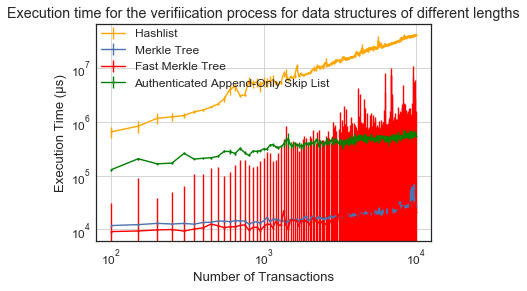

In [19]:
# build plot
title = 'Execution time for the verifiication process for data structures of different lengths'
plt.errorbar(lenghts, hl_veri_t_means, yerr=hl_veri_t_stds, marker='o', markersize=2, color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_veri_t_means, yerr=mt_veri_t_stds, marker='o', markersize=2, label='Merkle Tree')
plt.errorbar(lenghts, fmt_veri_t_means, yerr=fmt_build_t_stds, marker='o', markersize=2, color='red', label='Fast Merkle Tree')
plt.errorbar(lenghts, sl_veri_t_means, yerr=sl_veri_t_stds, marker='o', markersize=2, color='green', label='Authenticated Append-Only Skip List')
plt.title(title)
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Execution Time (µs)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
plt.savefig(toSnakeCase(title) + '.png', dpi = 400)
plt.xscale('log')
plt.yscale('log')
plt.savefig(toSnakeCase(title) + '_log.png', dpi = 400)
print('Done!')

Done!


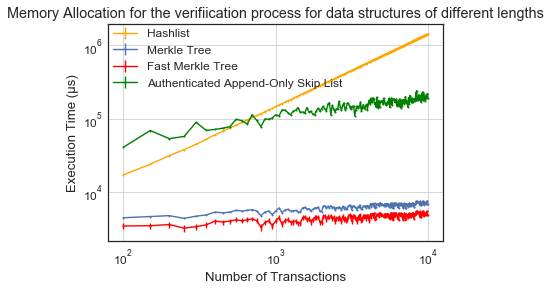

In [20]:
# build plot
title = 'Memory Allocation for the verifiication process for data structures of different lengths'
plt.errorbar(lenghts, hl_veri_m_means, yerr=hl_veri_m_stds, marker='o', markersize=2, color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_veri_m_means, yerr=mt_veri_m_stds, marker='o', markersize=2, label='Merkle Tree')
plt.errorbar(lenghts, fmt_veri_m_means, yerr=fmt_build_m_stds, marker='o', markersize=2, color='red', label='Fast Merkle Tree')
plt.errorbar(lenghts, sl_veri_m_means, yerr=sl_veri_m_stds, marker='o', markersize=2, color='green', label='Authenticated Append-Only Skip List')
plt.title(title)
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Memory Allocation (bytes)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
plt.savefig(toSnakeCase(title) + '.png', dpi = 400)
plt.xscale('log')
plt.yscale('log')
plt.savefig(toSnakeCase(title) + '_log.png', dpi = 400)
print('Done!')

### Void Time function analysis

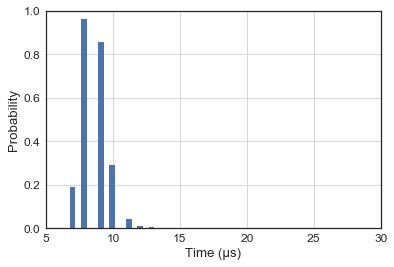

In [21]:
# 1.000.000 void runs with the time function used
#os.system("go build -o " + EXPERIMENT_PATH + "/thesis " + EXPERIMENT_PATH + "/*.go")
#os.system("rm " + EXPERIMENT_PATH + "/results/time.txt")
#os.system(EXPERIMENT_PATH + "/thesis -algo=time")


# build plot
title = 'Void Time function analysis'
text = np.loadtxt(EXPERIMENT_PATH  + "/results/time.txt", dtype='int', delimiter='\n')
#sns.distplot(text, hist=False, rug=True);
plt.hist(text, 50, density=True, facecolor='b', range=(3,24), histtype='stepfilled')
plt.xlabel('Time (μs)')
plt.ylabel('Probability')
#plt.title(title)
plt.axis([5, 30, 0, 1])
plt.grid(True)
plt.savefig(toSnakeCase(title) + '.png', dpi = 400)
plt.show()